# HealthCare Project

## Detection of Covid-19 from CT-Scans

### Importing Libararies

In [1]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from tensorflow.keras.initializers import HeUniform, VarianceScaling
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image
from skimage.transform import resize
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import progressbar
#from pathlib import Path

### Loading data function

In [2]:
def load_data(category, path, img_size=(32, 32)):
    #Variables
    
    corrupted={"count" : 0, "image_name" : [], "label" : []}
    Image_count = 0  
    Image_dir=[None]*len(category)
    
    for i in category.keys():
             Image_dir[category[i]]=glob.glob(path+i+"/*.png")        
        
    for idx, j in enumerate(Image_dir):
        for img in j:
            try:
                mpimg.imread(img)
            except:
                corrupted["count"] += 1
                corrupted["image_name"].append(img)
                corrupted["label"].append(idx)
            else:
                Image_count+=1
            
    for img, label in zip(corrupted['image_name'], corrupted["label"]):
            Image_dir[label].remove(img)
        
    Images = np.empty((Image_count, img_size[0], img_size[1], 1), dtype=np.float32)
    labels = np.empty((Image_count), dtype="int")
            
    c=0       
    for idx, k in enumerate(Image_dir):
            for img in k:
                Images[c] = resize(mpimg.imread(img), (img_size[0], img_size[1], 1), anti_aliasing=True)
                labels[c] = idx
                c+=1
                
    return Images, labels

### Binary Class Model

In [3]:
path = 'D:/Data Analytics for Business/DAB Semester-3/DAB 304 - Healthcare Analytics/DAB 304 - Final Project material/archive (1)/curated_data/curated_data/'
category = {"1NonCOVID":0,"2COVID":1}
img_size = (256, 256)

In [4]:
X, y = load_data(category, path, img_size)

In [5]:
X.shape, y.shape

((14449, 256, 256, 1), (14449,))

In [6]:
pd.Series(y).value_counts()

1    7556
0    6893
dtype: int64

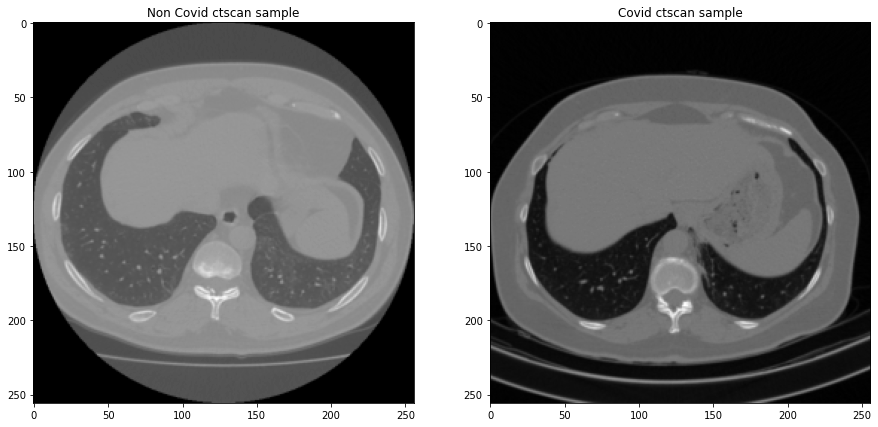

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

for ax, i in zip(axes.flatten(), [0, -3000]):
    ax.imshow(X[i], cmap='gray')
    if y[i]==0:
        ax.set_title('Non Covid ctscan sample')
    else:
        ax.set_title('Covid ctscan sample')

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    stratify = y, 
                                                    random_state=1)

In [18]:
epochs = 5
batch_size = 128
OPTIMIZER = tf.keras.optimizers.SGD(learning_rate=0.1)
#tf.keras.optimizers.Adam(learning_rate=0.01)
#img_size = (128, 128)

#### Baseline Model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 524288)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                33554496  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 33,554,881
Trainable params: 33,554,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
73/73 - 15s - loss: 8.1699 - accuracy: 0.8211 - val_loss: 0.3604 - val_accuracy: 0.8300
Epoch 2/5
73

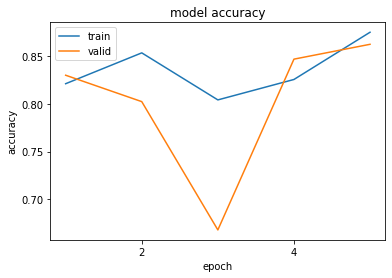

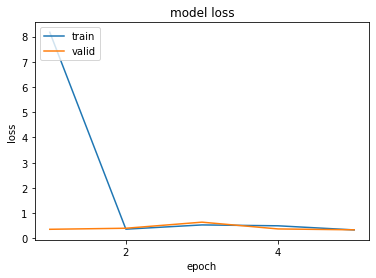

In [19]:
def binary_baseline_model():
    model = Sequential([
        Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer="he_normal", 
               input_shape=(img_size[0], img_size[1], 1)),
        Flatten(),
        Dense(1, activation='sigmoid', kernel_initializer="he_normal")
    ])
    model.compile(optimizer=OPTIMIZER,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

binary_baseline_model = binary_baseline_model()

binary_baseline_model.summary()

# Fitting the model (training and validation phase in multiple epochs)
history = binary_baseline_model.fit(X_train, y_train, validation_split = 0.2, epochs=epochs, batch_size=batch_size,
                                    shuffle=True, verbose = 2)

# summarize history for accuracy
plt.plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'])
plt.plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xticks(np.arange(2,epochs+1, 2.0))
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'])
plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(np.arange(2,epochs+1, 2.0))
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

#### Final Binary class model

In [10]:
def create_model():
    model = Sequential([
        Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer="he_normal", 
               input_shape=(img_size[0], img_size[1], 1)),
        Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer="he_normal"),
        Dropout(0.2),
        MaxPooling2D(pool_size = (2,2)),
        Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer="he_normal"),
        Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer="he_normal"),
        Dropout(0.2),
        MaxPooling2D(pool_size = (2,2)),
        Conv2D(128, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer="he_normal"),
        Conv2D(128, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer="he_normal"),
        MaxPooling2D(pool_size = (2,2)),
        Flatten(),
        Dense(64, activation='relu', kernel_initializer="he_normal"),
        Dropout(0.2),
        Dense(1, activation='sigmoid', kernel_initializer="he_normal")
    ])
    model.compile(optimizer=OPTIMIZER,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = create_model()

In [11]:
model.summary()

filepath = 'model.h1'

# Creating model checkpoint to save the best parameters based on validation accuracy
checkpoint = ModelCheckpoint(filepath = filepath, monitor = 'val_accuracy',save_best_only=True, mode = 'max',verbose = 1)

# Fitting the model (training and validation phase in multiple epochs)
history = model.fit(X_train, y_train, validation_split = 0.2, epochs=epochs, batch_size=batch_size, shuffle=True, verbose = 2,
                   callbacks = [checkpoint])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      9248      
_________________________________________________________________
dropout (Dropout)            (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 64)      0

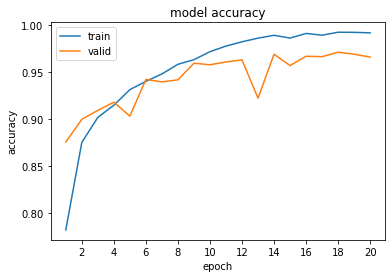

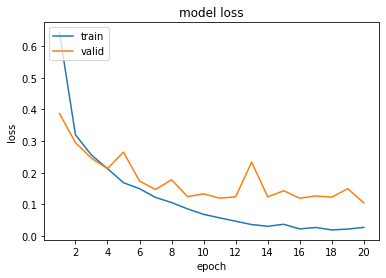

In [12]:
# summarize history for accuracy
plt.plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'])
plt.plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xticks(np.arange(2,epochs+1, 2.0))
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'])
plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(np.arange(2,epochs+1, 2.0))
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

#### Testing and evaluation of results

In [13]:
# Testing the model
y_pred = model.predict(X_test)
y_pred[y_pred>=0.5]=1
y_pred[y_pred<0.5]=0
#y_pred = y_pred.reshape(1, -1)

# Test accuracy socre
test_acc = accuracy_score(y_test, y_pred)
print('test_acc:', test_acc)

test_acc: 0.9698961937716263


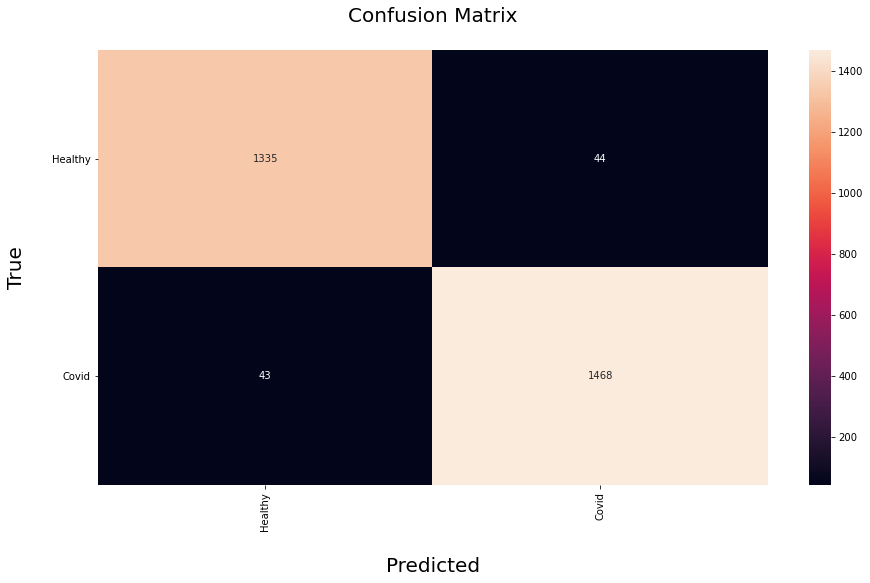

In [14]:
class_names = ["Healthy", "Covid"]

# Plotting Confusion matrix
cm = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm, class_names=class_names):
    # Plot confusion matrix in a beautiful manner
    fig = plt.figure(figsize=(15, 8))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
    # labels, title and ticks
    ax.set_xlabel('\nPredicted', fontsize=20)
    ax.xaxis.set_label_position('bottom')
    plt.xticks(rotation=90)
    ax.xaxis.set_ticklabels(class_names, fontsize = 10)
    ax.xaxis.tick_bottom()

    ax.set_ylabel('True\n', fontsize=20)
    ax.yaxis.set_ticklabels(class_names, fontsize = 10)
    plt.yticks(rotation=0)

    plt.title('Confusion Matrix\n', fontsize=20)
    plt.show()

plot_confusion_matrix(cm)

In [15]:
from sklearn.metrics import precision_score
precision_score(y_test, y_pred)

0.9708994708994709

In [16]:
from sklearn.metrics import recall_score
recall_score(y_test, y_pred)

0.971542025148908

In [17]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

0.9712206417466094

#### Wrongly classified Test images

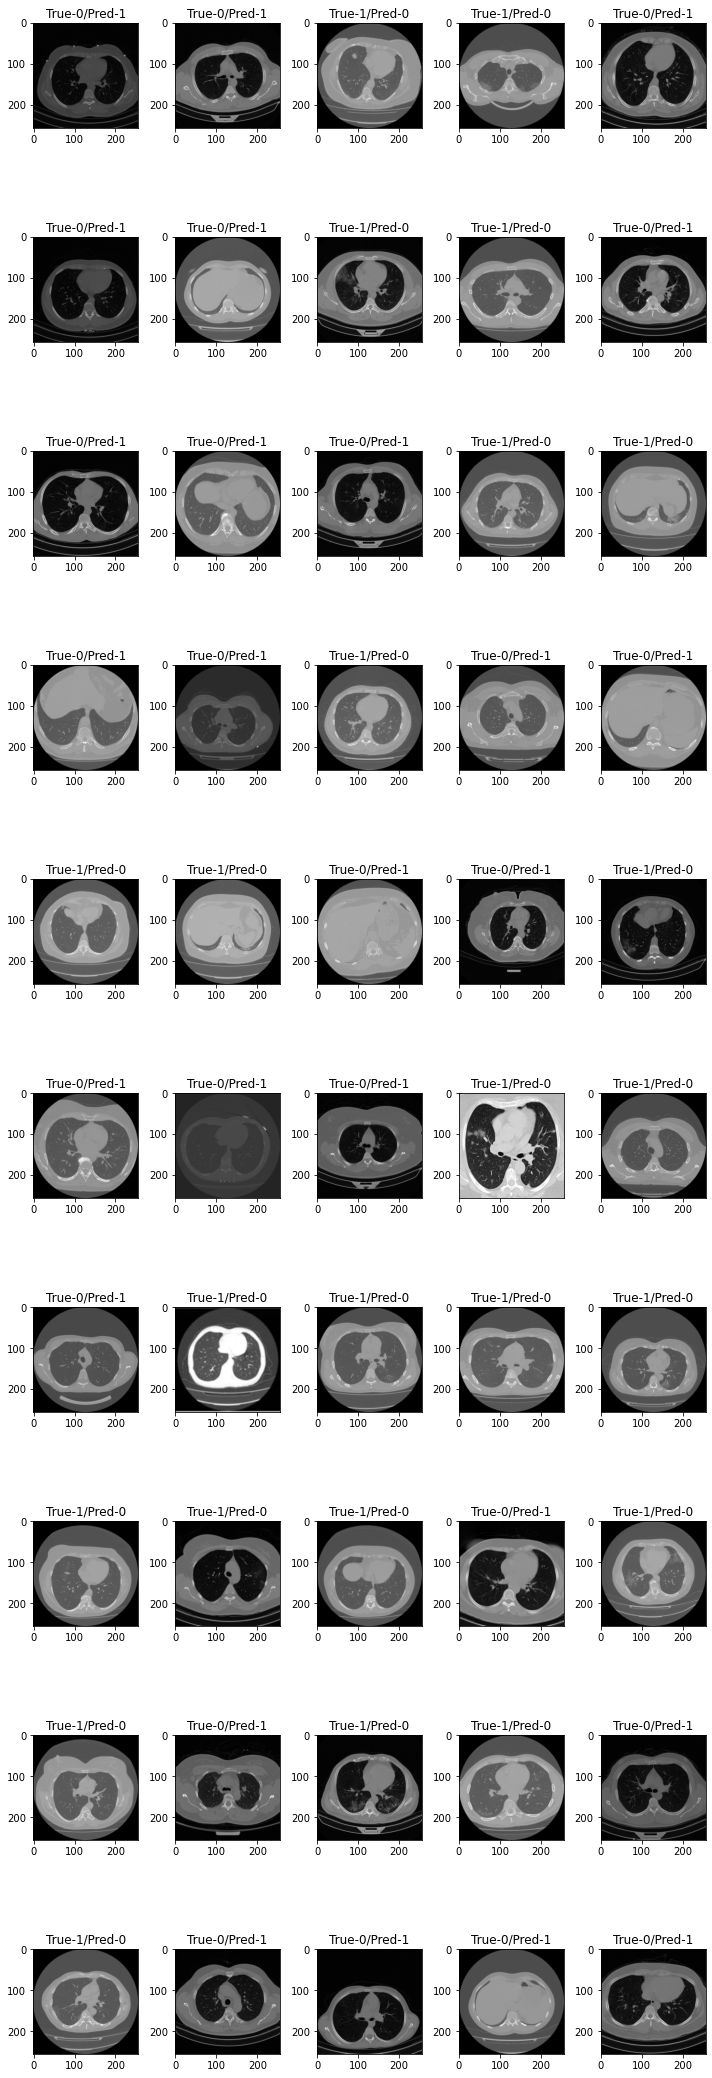

In [18]:
labels = (y_test)!=(y_pred.reshape(y_pred.shape[0],))

fig, axes = plt.subplots(10, 5, figsize=(10,30))

for x,ax,y,p in zip(X_test[labels], axes.flatten(), y_test[labels], y_pred.reshape(y_pred.shape[0],)[labels]):
    ax.imshow(x, cmap='gray')
    ax.set_title("True-"+str(int(y))+'/Pred-'+str(int(p)))

plt.tight_layout()
plt.show()

#### Sample of correctly classified Images

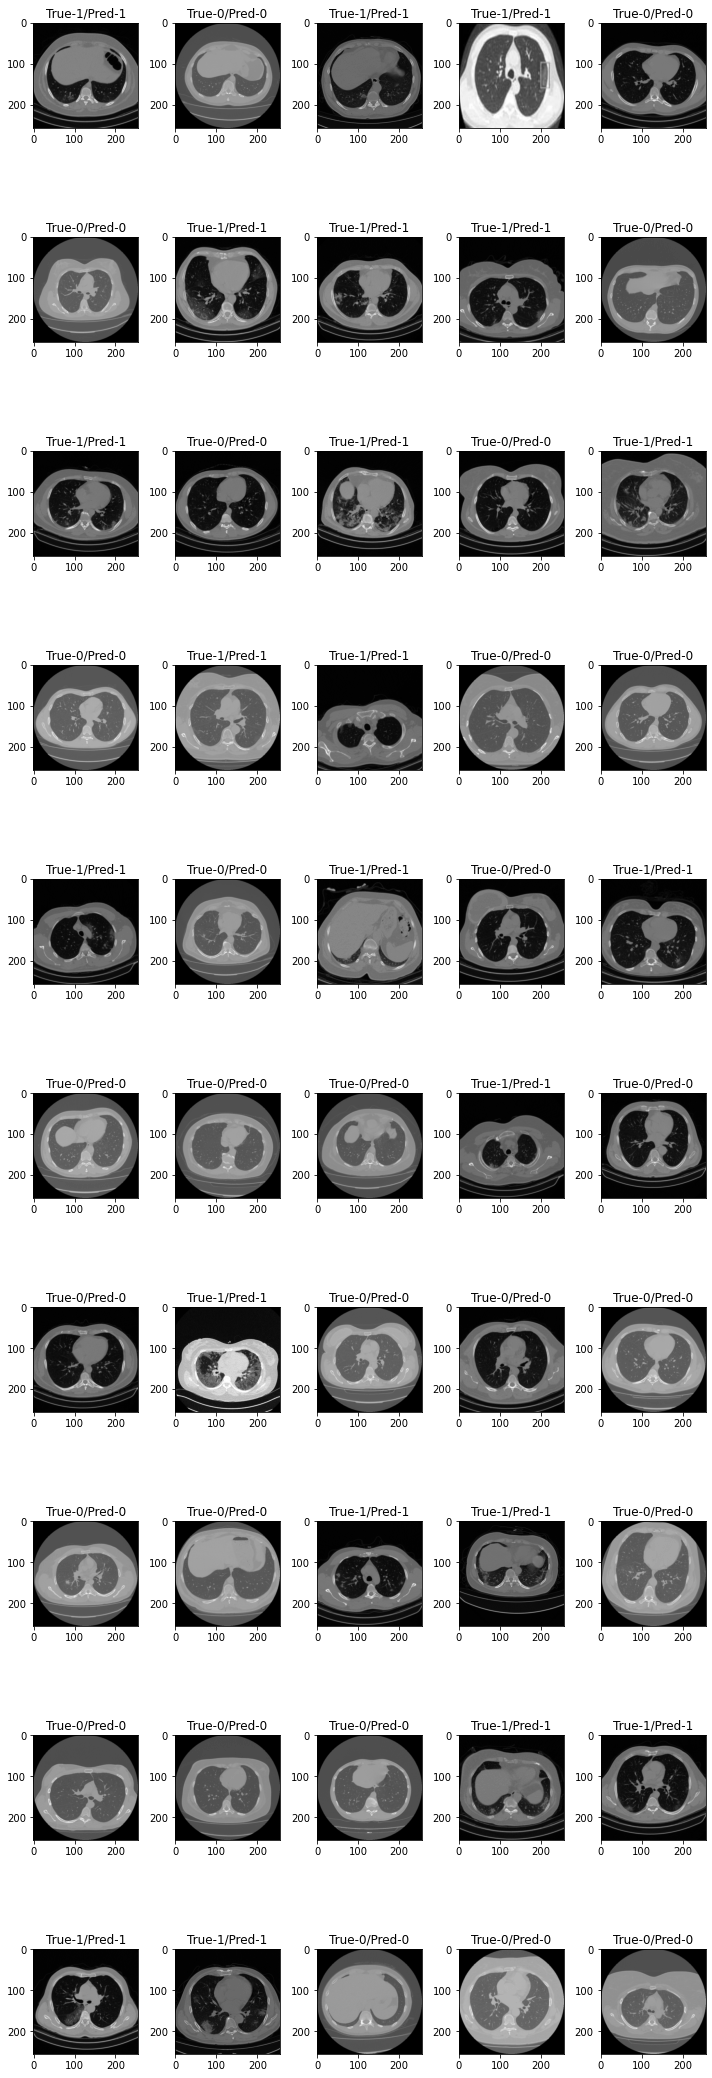

In [19]:
labels = (y_test)==(y_pred.reshape(y_pred.shape[0],))

fig, axes = plt.subplots(10, 5, figsize=(10,30))

for x,ax,y,p in zip(X_test[labels], axes.flatten(), y_test[labels], y_pred.reshape(y_pred.shape[0],)[labels]):
    ax.imshow(x, cmap='gray')
    ax.set_title("True-"+str(int(y))+'/Pred-'+str(int(p)))

plt.tight_layout()
plt.show()

### Multi-Class Model

In [36]:
path = 'D:/Data Analytics for Business/DAB Semester-3/DAB 304 - Healthcare Analytics/DAB 304 - Final Project material/archive (1)/curated_data/curated_data/'
category = {"1NonCOVID":0,"2COVID":1, "3CAP":2}
img_size = (256, 256)

In [21]:
X, y = load_data(category, path, img_size)

In [22]:
X.shape, y.shape

((17067, 256, 256, 1), (17067,))

In [23]:
pd.Series(y).value_counts()

1    7556
0    6893
2    2618
dtype: int64

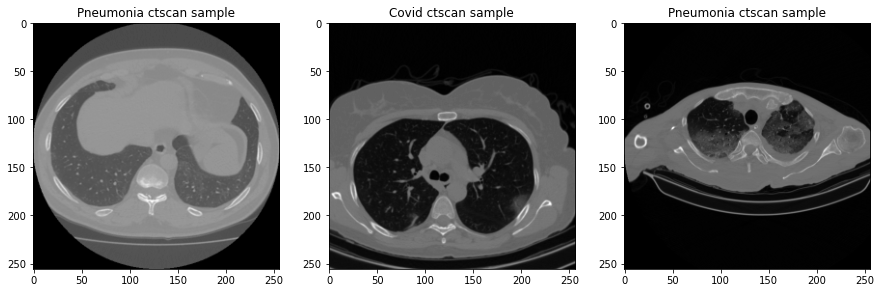

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(15, 10))

for ax, i in zip(axes.flatten(), [0, -3000, -1]):
    ax.imshow(X[i], cmap='gray')
    if y[i]==0:
        ax.set_title('Non Covid ctscan sample')
    if y[i]==1:
        ax.set_title('Covid ctscan sample')
    else:
        ax.set_title('Pneumonia ctscan sample')

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    stratify = y, 
                                                    random_state=1)

In [38]:
# Converting labels to one-hot-encoded labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [29]:
epochs = 5
batch_size = 32
OPTIMIZER = tf.keras.optimizers.SGD(learning_rate=0.1)
#tf.keras.optimizers.Adam(learning_rate=0.01)
#img_size = (128, 128)

#### Baseline Model

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 256, 256, 64)      640       
_________________________________________________________________
flatten_11 (Flatten)         (None, 4194304)           0         
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 12582915  
Total params: 12,583,555
Trainable params: 12,583,555
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
342/342 - 40s - loss: 11.5049 - accuracy: 0.5378 - val_loss: 0.9988 - val_accuracy: 0.4570
Epoch 2/5
342/342 - 39s - loss: 1.0009 - accuracy: 0.4652 - val_loss: 0.7861 - val_accuracy: 0.6899
Epoch 3/5
342/342 - 39s - loss: 0.9760 - accuracy: 0.4838 - val_loss: 1.0114 - val_accuracy: 0.4570
Epoch 4/5
342/342 - 39s - loss: 1.0154 - accuracy: 0.4398 - val_loss: 

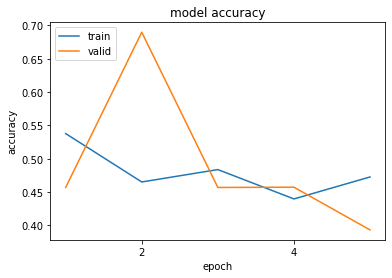

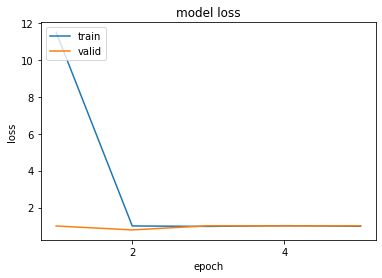

In [39]:
def multi_class_baseline_model():
    model = Sequential([
        Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer="he_normal", 
               input_shape=(img_size[0], img_size[1], 1)),
        Flatten(),
        Dense(3, activation='softmax', kernel_initializer="he_normal")
    ])
    model.compile(optimizer=OPTIMIZER,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

multi_class_baseline_model = multi_class_baseline_model()

multi_class_baseline_model.summary()

history = multi_class_baseline_model.fit(X_train, y_train, validation_split = 0.2, epochs=epochs, batch_size=batch_size, shuffle=True, verbose = 2)

# summarize history for accuracy
plt.plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'])
plt.plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xticks(np.arange(2,epochs+1, 2.0))
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'])
plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(np.arange(2,epochs+1, 2.0))
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

#### Final Multi-Class Model

In [31]:
def create_model():
    model = Sequential([
        Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer="he_normal", 
               input_shape=(img_size[0], img_size[1], 1)),
        Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer="he_normal"),
        Dropout(0.2),
        MaxPooling2D(pool_size = (2,2)),
        Conv2D(128, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer="he_normal"),
        Conv2D(128, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer="he_normal"),
        Dropout(0.2),
        MaxPooling2D(pool_size = (2,2)),
        Conv2D(256, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer="he_normal"),
        Conv2D(256, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer="he_normal"),
        MaxPooling2D(pool_size = (2,2)),
        Flatten(),
        Dense(512, activation='relu', kernel_initializer="he_normal"),
        Dropout(0.2),
        Dense(3, activation='softmax', kernel_initializer="he_normal")
    ])
    model.compile(optimizer=OPTIMIZER,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = create_model()

In [32]:
model.summary()

filepath = 'model.h2'

# Creating model checkpoint to save the best parameters based on validation accuracy
checkpoint = ModelCheckpoint(filepath = filepath, monitor = 'val_accuracy',save_best_only=True, mode = 'max',verbose = 1)

# Fitting the model (training and validation phase in multiple epochs)
history = model.fit(X_train, y_train, validation_split = 0.2, epochs=epochs, batch_size=batch_size, shuffle=True, verbose = 2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 256, 256, 64)      640       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256, 256, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 128)     147584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128, 128, 128)    

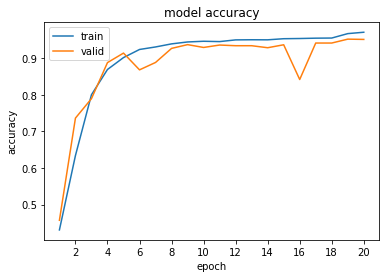

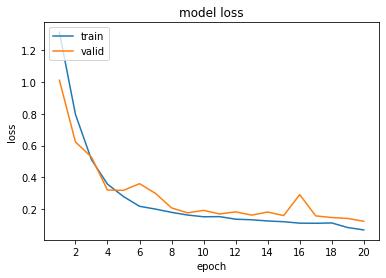

In [33]:
# summarize history for accuracy
plt.plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'])
plt.plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xticks(np.arange(2,epochs+1, 2.0))
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'])
plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(np.arange(2,epochs+1, 2.0))
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

#### Testing and Evaluation of Results

In [34]:
# Testing the model
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)


# Test accuracy socre
test_acc = accuracy_score(y_true, y_pred)
print('test_acc:', test_acc)

test_acc: 0.9581136496777973


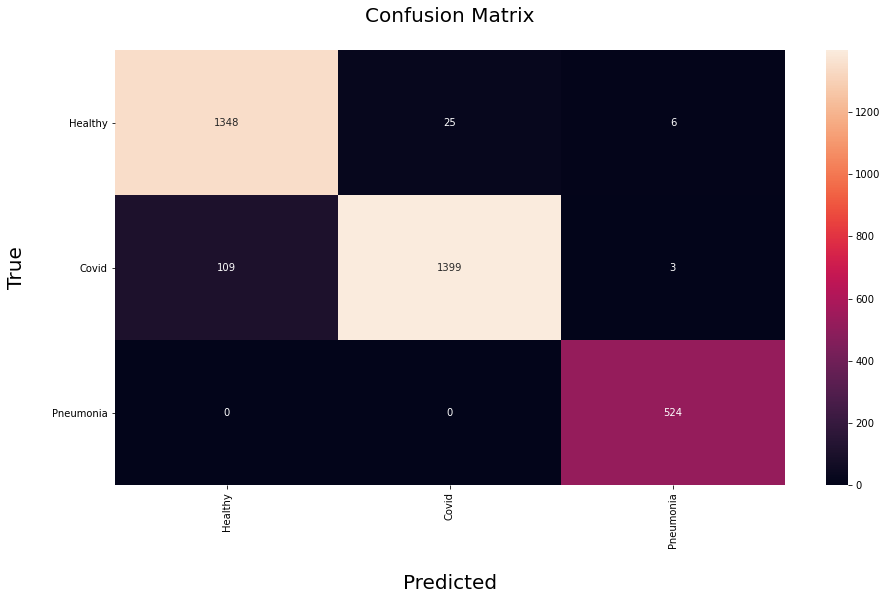

In [35]:
# Class Labels
class_names = ['Healthy', 'Covid', 'Pneumonia']

# Plotting Confusion matrix
cm = confusion_matrix(y_true, y_pred)

def plot_confusion_matrix(cm, class_names=class_names):
    # Plot confusion matrix in a beautiful manner
    fig = plt.figure(figsize=(15, 8))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
    # labels, title and ticks
    ax.set_xlabel('\nPredicted', fontsize=20)
    ax.xaxis.set_label_position('bottom')
    plt.xticks(rotation=90)
    ax.xaxis.set_ticklabels(class_names, fontsize = 10)
    ax.xaxis.tick_bottom()

    ax.set_ylabel('True\n', fontsize=20)
    ax.yaxis.set_ticklabels(class_names, fontsize = 10)
    plt.yticks(rotation=0)

    plt.title('Confusion Matrix\n', fontsize=20)
    plt.show()

plot_confusion_matrix(cm)